In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [23]:
import os
from zipfile import ZipFile

data_path = r"C:\Users\arnav\OneDrive\Desktop\vision_dataset.zip"
extract_path = r"C:\Users\arnav\OneDrive\Desktop"  
# Extract the zip file
with ZipFile(data_path, 'r') as zip:
    zip.extractall(extract_path)
    print('The data set has been extracted.')

The data set has been extracted.


In [24]:

path = r"C:\Users\arnav\OneDrive\Desktop\lung_colon_image_set\lung_image_sets"  

# Check if the path exists and list directories
if os.path.exists(path):
   classes = os.listdir(path)
   print(classes)
else:
    print(f"Path does not exist: {path}")

['lung_aca', 'lung_n', 'lung_scc']


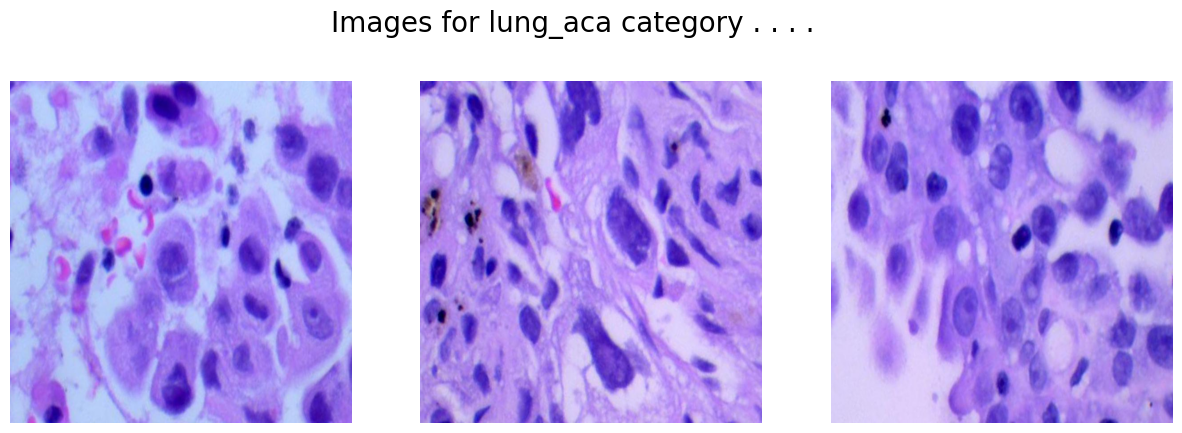

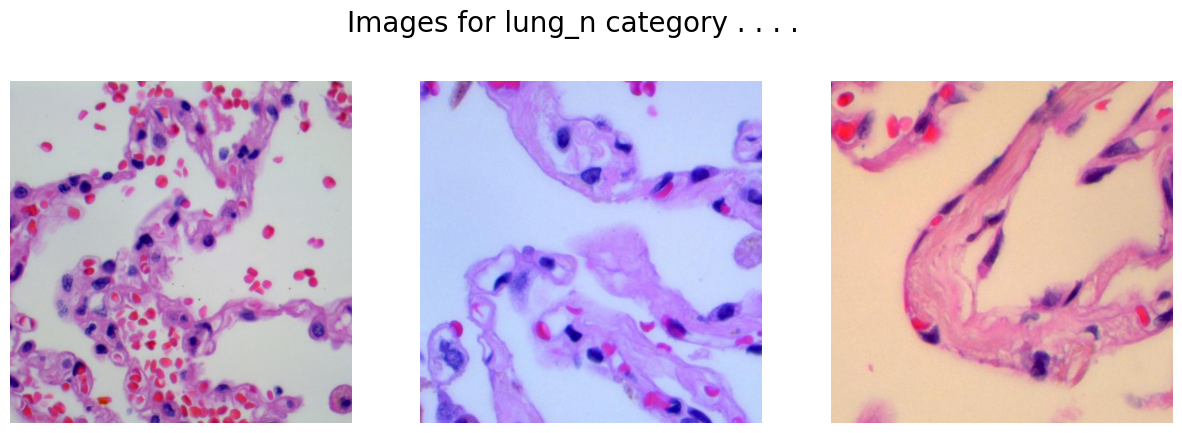

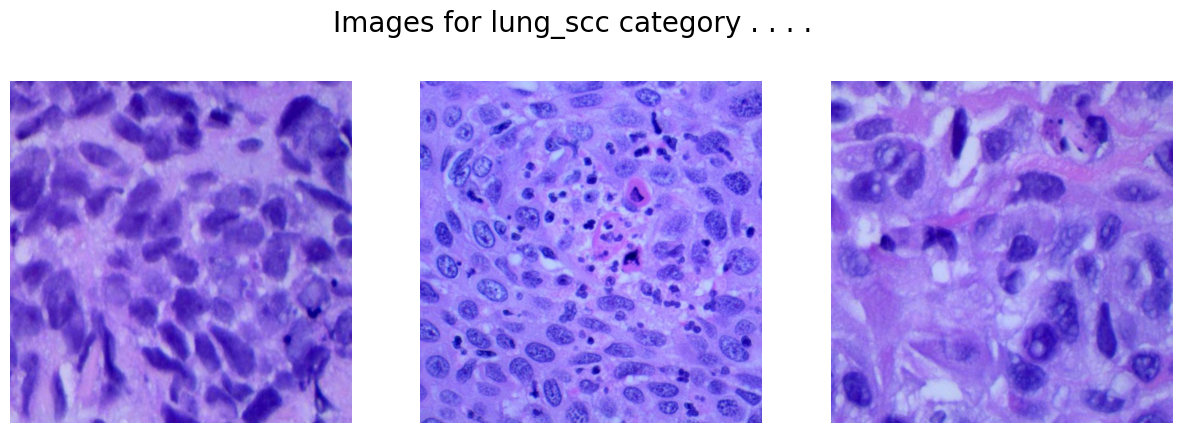

In [25]:
path = r"C:\Users\arnav\OneDrive\Desktop\lung_colon_image_set\lung_image_sets"

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize = (15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', 
				fontsize = 20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()

In [26]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [27]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')

    for image in images:
    	img = cv2.imread(image)
	
    	X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    	Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [28]:
classes = os.listdir(path)
print("Class order:", classes)

Class order: ['lung_aca', 'lung_n', 'lung_scc']


In [29]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [30]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
	input_shape = (IMG_SIZE, IMG_SIZE, 3),
	weights = 'imagenet',
	include_top = False
)

In [31]:
len(pre_trained_model.layers)

311

In [32]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [33]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 768)


In [34]:
x = layers.Flatten()(last_output)

x = layers.Dense(256,activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(3, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

In [35]:
model.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

In [36]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
    	if logs.get('val_accuracy') > 0.90:
        	print('\n Validation accuracy has reached upto 90%\
        	so, stopping further training.')
        	self.model.stop_training = True

es = EarlyStopping(patience = 3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
					patience = 2,
					factor = 0.5,
					verbose = 1)

In [37]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 [==============================] - 199s 1s/step - loss: 0.3710 - accuracy: 0.8497 - val_loss: 1.7017 - val_accuracy: 0.4540 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 418s 2s/step - loss: 0.2132 - accuracy: 0.9146 - val_loss: 0.2562 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 414s 2s/step - loss: 0.1705 - accuracy: 0.9321 - val_loss: 0.2859 - val_accuracy: 0.8807 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - ETA: 0s - loss: 0.1332 - accuracy: 0.9468
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 [==============================] - 415s 2s/step - loss: 0.1332 - accuracy: 0.9468 - val_loss: 0.6938 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 424s 2s/step - loss: 0.0929 - accuracy: 0.9668 - val_loss: 0.9860 - val_accuracy: 0.7863 - lr: 5.0000e-04


In [38]:
# Saving the trained model
model.save(r"C:\Users\arnav\OneDrive\Desktop\model3.h5")

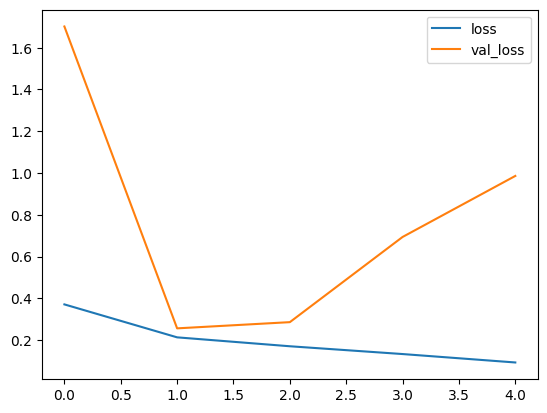

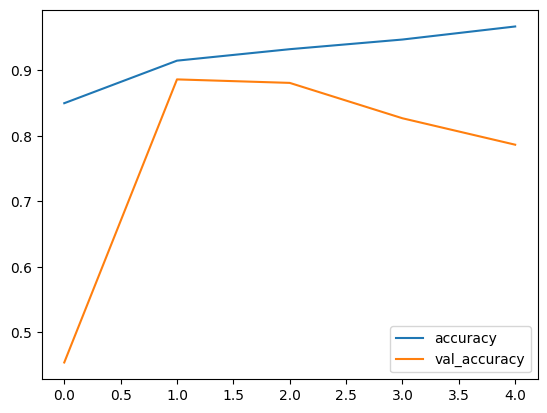

In [39]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [40]:
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 [==============================] - 43s 445ms/step


In [41]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[890,  26,  71],
       [ 28, 948,   1],
       [214,   2, 820]], dtype=int64)

In [42]:
print(metrics.classification_report(Y_val, Y_pred, target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.79      0.90      0.84       987
      lung_n       0.97      0.97      0.97       977
    lung_scc       0.92      0.79      0.85      1036

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000

